# 使用卷积神经网络进行图像分类

本示例教程将会演示如何使用飞桨的卷积神经网络来完成图像分类任务。这是一个较为简单的示例，将会使用一个由三个卷积层组成的网络完成[cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)数据集的图像分类任务。

## 设置环境

我们将使用飞桨2.0beta版本。

In [3]:
import paddle
import paddle.nn.functional as F
from paddle.vision.transforms import Normalize
import numpy as np
import matplotlib.pyplot as plt

paddle.disable_static()
print(paddle.__version__)

2.0.0-beta0


## 加载并浏览数据集

我们将会使用飞桨提供的API完成数据集的下载并为后续的训练任务准备好数据迭代器。cifar10数据集由60000张大小为32 * 32的彩色图片组成，其中有50000张图片组成了训练集，另外10000张图片组成了测试集。这些图片分为10个类别，我们的任务是训练一个模型能够把图片进行正确的分类。

In [4]:
cifar10_train = paddle.vision.datasets.cifar.Cifar10(mode='train', transform=None)

train_images = np.zeros((50000, 32, 32, 3), dtype='float32')
train_labels = np.zeros((50000, 1), dtype='int32')
for i, data in enumerate(cifar10_train):
    train_image, train_label = data
    train_image = train_image.reshape((3, 32, 32 )).astype('float32') / 255.
    train_image = train_image.transpose(1, 2, 0)
    train_images[i, :, :, :] = train_image
    train_labels[i, 0] = train_label

## 浏览数据集

接下来我们从数据集中随机挑选一些图片并显示，从而对数据集有一个直观的了解。

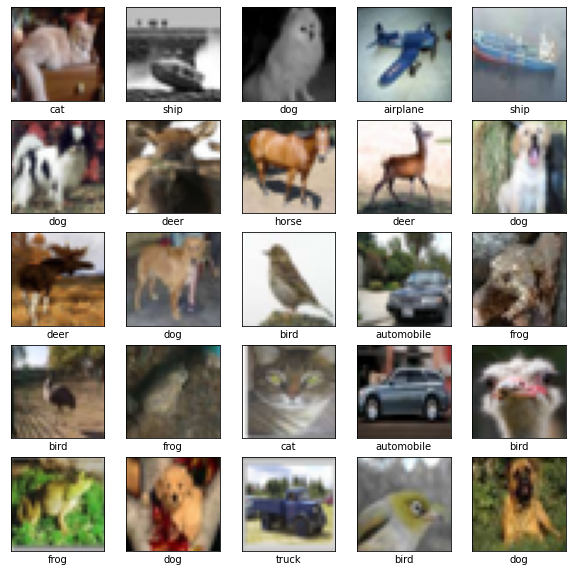

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
sample_idxs = np.random.choice(50000, size=25, replace=False)

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[sample_idxs[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[sample_idxs[i]][0]])
plt.show()

## 组建网络

接下来我们使用飞桨定义一个使用了三个二维卷积（`Conv2d`)且每次卷积之后使用`relu`激活函数，两个二维池化层（`MaxPool2d`），和两个线性变换层组成的分类网络，来把一个`(32, 32, 3)`形状的图片通过卷积神经网络映射为10个输出，这对应着10个分类的类别。

In [6]:
class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = paddle.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2d(kernel_size=2, stride=2)    
        
        self.conv3 = paddle.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()
        
        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## 模型训练

接下来，我们用一个循环来进行模型的训练，我们将会：
- 使用`paddle.optimizer.Adam`优化器来进行优化。
- 使用`F.softmax_with_cross_entropy`来计算损失值。
- 使用`paddle.io.DataLoader`来加载数据并组建batch。


In [7]:
epoch_num = 10
batch_size = 32
learning_rate = 0.001

In [8]:
val_acc_history = []
val_loss_history = []

def train(model):
    print('start training ... ')
    # turn into training mode
    model.train()

    opt = paddle.optimizer.Adam(learning_rate=learning_rate, 
                                parameters=model.parameters())

    train_loader = paddle.io.DataLoader(cifar10_train,
                                        places=paddle.CPUPlace(), 
                                        shuffle=True, 
                                        batch_size=batch_size)
    
    cifar10_test = paddle.vision.datasets.cifar.Cifar10(mode='test', transform=None)
    valid_loader = paddle.io.DataLoader(cifar10_test, places=paddle.CPUPlace(), batch_size=batch_size)

    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data = paddle.cast(data[0], 'float32')
            x_data = paddle.reshape(x_data, (-1, 3, 32, 32)) / 255.0
            
            y_data = paddle.cast(data[1], 'int64')
            y_data = paddle.reshape(y_data, (-1, 1))
                        
            logits = model(x_data)
            loss = F.softmax_with_cross_entropy(logits, y_data)
            avg_loss = paddle.mean(loss)
            
            if batch_id % 1000 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()): 
            x_data = paddle.cast(data[0], 'float32')
            x_data = paddle.reshape(x_data, (-1, 3, 32, 32)) / 255.0
            
            y_data = paddle.cast(data[1], 'int64')
            y_data = paddle.reshape(y_data, (-1, 1))           
            
            logits = model(x_data)            
            loss = F.softmax_with_cross_entropy(logits, y_data)
            acc = paddle.metric.accuracy(logits, y_data)
            accuracies.append(np.mean(acc.numpy()))
            losses.append(np.mean(loss.numpy()))
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print("[validation] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
        val_acc_history.append(avg_acc)
        val_loss_history.append(avg_loss)
        model.train()

model = MyNet(num_classes=10)
train(model)

start training ... 
epoch: 0, batch_id: 0, loss is: [2.331658]
epoch: 0, batch_id: 1000, loss is: [1.6067888]
[validation] accuracy/loss: 0.5676916837692261/1.2106356620788574
epoch: 1, batch_id: 0, loss is: [1.1509854]
epoch: 1, batch_id: 1000, loss is: [1.3777964]
[validation] accuracy/loss: 0.5818690061569214/1.1748384237289429
epoch: 2, batch_id: 0, loss is: [1.051642]
epoch: 2, batch_id: 1000, loss is: [1.0261706]
[validation] accuracy/loss: 0.6607428193092346/0.9685573577880859
epoch: 3, batch_id: 0, loss is: [0.8457774]
epoch: 3, batch_id: 1000, loss is: [0.6820123]
[validation] accuracy/loss: 0.6822084784507751/0.9241172075271606
epoch: 4, batch_id: 0, loss is: [0.9059805]
epoch: 4, batch_id: 1000, loss is: [0.587117]
[validation] accuracy/loss: 0.7012779712677002/0.8670551180839539
epoch: 5, batch_id: 0, loss is: [1.0894825]
epoch: 5, batch_id: 1000, loss is: [0.9055369]
[validation] accuracy/loss: 0.6954872012138367/0.8820587992668152
epoch: 6, batch_id: 0, loss is: [0.416258

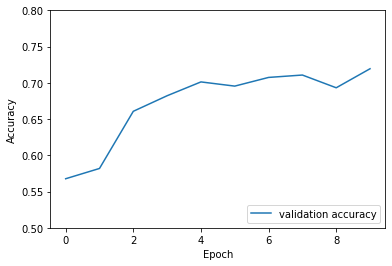

In [9]:
plt.plot(val_acc_history, label = 'validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.8])
plt.legend(loc='lower right')

## The End

从上面的示例可以看到，在cifar10数据集上，使用简单的卷积神经网络，用飞桨可以达到71%以上的准确率。你也可以通过调整网络结构和参数，达到更好的效果。